<div style="text-align: right">INFO 7390 Advances Data Sci/Architecture Project</div>
<div style="text-align: right">Divyanshu Bhardwaj</div>


# Intracranial Hemorrhages Classification

* Diagnosis of intracranial hemorrhages is an important challenge in the medical field as they can be fatal. 
* Intracranial hemorrhage is bleeding that occurs inside the cranium
* Identifying the location and type of any hemorrhage present is a critical step in treating the patient



<center>
<img src="images/classification1.png" width=1000 />
</center>


## Problem Statement 

* The detection and classification of cerebral hemorrhages is the challenge that we focused on. 
* For patients with brain hemorrhages to have a better chance of surviving, an immediate diagnosis of the kind of hemorrhage and subsequent treatment are required. 
* It has been demonstrated that machine learning models are quite effective in helping doctors classify cerebral hemorrhages using multi-label 6-class classification (normal, epidural, intraparenchymal, intraventricular, subarachnoid, and subdural). 


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from random import *
from zipfile import ZipFile
from PIL import Image
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
from fastai.vision.all import * 

## Harvesting Data 

> For data we are using [RSNA hemorrhage JPEGs images](https://www.kaggle.com/datasets/jhoward/rsna-hemorrhage-jpg)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
label_df = pd.read_csv('/content/drive/MyDrive/data_cnn/label_Df.csv')
label_df

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_00008ce3c,0,0,0,0,0,0
1,ID_0000aee4b,0,0,0,0,0,0
2,ID_0002003a8,0,0,0,0,0,0
3,ID_0002081b6,1,0,1,0,0,0
4,ID_00027cbb1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
193521,ID_fffd8342d,0,0,0,0,0,0
193522,ID_ffff53123,0,0,0,0,0,0
193523,ID_ffff73ede,0,0,0,0,0,0
193524,ID_ffff80705,0,0,0,0,0,0


In [ ]:
train_images_dataset = get_image_files('/content/drive/MyDrive/data_cnn/train')

def read_image(x, mode = 'L'): return PILImage.create(x, mode = mode)
def read_images(imgs, **kwargs): return L([read_image(x, **kwargs) for x in imgs])

train_imgs = read_images(train_images_dataset[:200])
np.random.shuffle(train_imgs)

def display_images(x, nrows = 5, ncols = 5, title = None):
    fig=plt.figure(figsize=(9, 9))
    if title: plt.title(title)
    for i in range(1, ncols*nrows +1):
        ds = x[i]
        fig.add_subplot(nrows, ncols, i)
        plt.imshow(ds, cmap=plt.cm.bone)
        fig.add_subplot


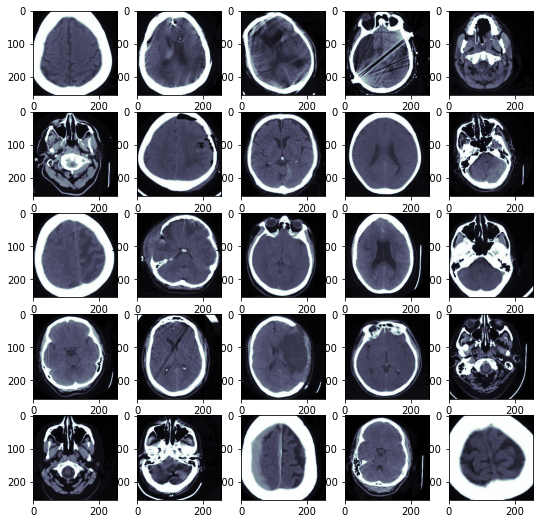

In [ ]:
display_images(train_imgs)

## Data Preparation and pre processing

> ###  make_data definition 
> * reads all the images in the data set folder, processes the image by resizing it in 64,64 bits pixels
> * All the images are then appended into a numpy array series

In [ ]:
def make_data(directory,df):
    
    X = []
    y = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            path = os.path.join(directory,filename)
            img = cv2.imread(path,cv2.IMREAD_COLOR)
            img = cv2.resize(img, (64,64))
            img = np.array(img)
            X.append(img)
            for i in range(len(df)):
                if (df['ID'][i] == filename.split('.')[0]):
                    y.append(df['y'][i])
                    break
    return np.asarray(X), np.asarray(y)

> ### make_dataframe 
> * function is responsible for mapping and classifying the images based on the location of bleed present with the help of label csv file
> * Depending on the location of bleeds we have clssified the haemorrhages as follows :
    * Type epidural we assign 1
    * Type intraparenchymal we assign 2
    * Type intraventricular we assign 3
    * Type subarachnoid we assign 4
    * Type subdural we assign 5

In [ ]:
def make_dataframe(folder_directory,label_df):
    list_of_imgs_dir = []
    for root, dirs, files in os.walk(folder_directory):
        for filename in files:
            list_of_imgs_dir.append(filename.split('.')[0])
    list_of_imgs_dir_df = pd.DataFrame(list_of_imgs_dir,columns=['ID'])
    y_label_df = pd.merge(label_df,list_of_imgs_dir_df,how='inner',on = 'ID')
    y_label_df['y'] = 0
    for i in range(len(y_label_df)):
        if (y_label_df['epidural'][i] == 0 & y_label_df['intraparenchymal'][i] == 0 & y_label_df['intraventricular'][i] == 0 & y_label_df['subarachnoid'][i] == 0 & y_label_df['subdural'][i] == 0):
            y_label_df['y'][i] = 0
        if y_label_df['epidural'][i] == 1:
            y_label_df['y'][i] = 1
        if y_label_df['intraparenchymal'][i] == 1:
            y_label_df['y'][i] = 2
        if y_label_df['intraventricular'][i] == 1:
            y_label_df['y'][i] = 3
        if y_label_df['subarachnoid'][i] == 1:
            y_label_df['y'][i] = 4
        if y_label_df['subdural'][i] == 1:
            y_label_df['y'][i] = 5
    
    return y_label_df

> ### img_not_existing 
> * function checks whether an image is present in data set to be able to map it to the labels csv file

In [ ]:
def img_not_existing(directory,df):
    Image_ID_small = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            Image_ID_small.append(filename.split('.')[0])
    len(Image_ID_small)
    not_present = []
    for i in range(len(Image_ID_small)):
        if Image_ID_small[i] not in list(df['ID']):
            not_present.append(Image_ID_small[i])
    return not_present

## Train vs. Validation vs. Test set

> For training and testing purposes of our model, we have our data broken down into three distinct dataset splits.


> ### Training Set
> * It is the set of data that is used to train and make the model learn the hidden features/patterns in the data.
> * In each epoch, the same training data is fed to the neural network architecture repeatedly, and the model continues to learn the features of the data.


In [ ]:
train_not_exisiting = img_not_existing(r'/content/drive/MyDrive/data_cnn/train/',label_df)
train_not_exisiting

[]

In [ ]:
y_label_train_df = make_dataframe(r'/content/drive/MyDrive/data_cnn/train/',label_df)
X_train, y_train = make_data(r'/content/drive/MyDrive/data_cnn/train/',y_label_train_df)

In [ ]:
len(X_train),len(y_train)

(2485, 2485)

In [ ]:
X_train = X_train/255.0

> ### Validation Set
> * The validation set is a set of data, separate from the training set, that is used to validate our model performance during training.
> * This validation process gives information that helps us tune the model’s hyperparameters and configurations accordingly. It is like a critic telling us whether the training is moving in the right direction or not.
>* The main idea of splitting the dataset into a validation set is to prevent our model from overfitting i.e., the model becomes really good at classifying the samples in the training set but cannot generalize and make accurate classifications on the data it has not seen before.

In [ ]:
validation_not_exisiting = img_not_existing(r'/content/drive/MyDrive/data_cnn/validation/',label_df)
validation_not_exisiting

[]

In [ ]:
y_label_val_df = make_dataframe(r'/content/drive/MyDrive/data_cnn/validation',label_df)
X_validation, y_validation = make_data(r'/content/drive/MyDrive/data_cnn/validation/',y_label_val_df)

In [ ]:
len(X_validation), len(y_validation)

(248, 248)

In [ ]:
X_validation = X_validation/255.0

> ### Test Set
> * The test set is a separate set of data used to test the model after completing the training.
>* It provides an unbiased final model performance metric in terms of accuracy, precision, etc. 

In [ ]:
test_not_exisiting = img_not_existing(r'/content/drive/MyDrive/data_cnn/test/',label_df)
test_not_exisiting

[]

In [ ]:
y_label_test_df = make_dataframe(r'/content/drive/MyDrive/data_cnn/test/',label_df)
X_test, y_test = make_data(r'/content/drive/MyDrive/data_cnn/test/',y_label_test_df)

In [ ]:
len(X_test),len(y_test)

(250, 250)

In [ ]:
X_test = X_test/255.0

#  Deep Learning Models


## 1. Artificial Neural Network  

* Artificial Neural Network, or ANN, is a group of multiple perceptrons/ neurons at each layer. ANN is also known as a Feed-Forward Neural network because inputs are processed only in the forward direction
* The input layer accepts the inputs, the hidden layer processes the inputs, and the output layer produces the result
* Activation functions introduce nonlinear properties to the network. This helps the network learn any complex relationship between input and output


<center>
<img src="images/ann.gif" width=1000 />
</center>



> * Fitting the ANN model with dense layers of 3000, 1000 and 6 with their activation functions respectively
> * Using the Stochastic Gradient Descent algorithm for optimization

In [ ]:
ann = models.Sequential([
        layers.Flatten(input_shape=(64,64,3)),
        layers.Dense(3000, activation='relu'),
        layers.Dense(1000, activation='relu'),
        layers.Dense(6, activation='sigmoid')    
    ])

ann.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_ann = ann.fit(X_train, y_train, epochs=20)

Epoch 1/20
78/78 [==============================] - 15s 183ms/step - loss: 1.4553 - accuracy: 0.4588
Epoch 2/20
78/78 [==============================] - 12s 157ms/step - loss: 1.2693 - accuracy: 0.4913
Epoch 3/20
78/78 [==============================] - 12s 157ms/step - loss: 1.2301 - accuracy: 0.5002
Epoch 4/20
78/78 [==============================] - 12s 157ms/step - loss: 1.2047 - accuracy: 0.5087
Epoch 5/20
78/78 [==============================] - 12s 159ms/step - loss: 1.1746 - accuracy: 0.5268
Epoch 6/20
78/78 [==============================] - 12s 158ms/step - loss: 1.1531 - accuracy: 0.5421
Epoch 7/20
78/78 [==============================] - 12s 159ms/step - loss: 1.1151 - accuracy: 0.5497
Epoch 8/20
78/78 [==============================] - 13s 162ms/step - loss: 1.1044 - accuracy: 0.5586
Epoch 9/20
78/78 [==============================] - 13s 170ms/step - loss: 1.0868 - accuracy: 0.5650
Epoch 10/20
78/78 [==============================] - 13s 167ms/step - loss: 1.0495 - accura

In [ ]:
ann.evaluate(X_validation,  y_validation)

8/8 [==============================] - 1s 77ms/step - loss: 1.2445 - accuracy: 0.5242


[1.2444634437561035, 0.524193525314331]

In [ ]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 3000)              36867000  
                                                                 
 dense_1 (Dense)             (None, 1000)              3001000   
                                                                 
 dense_2 (Dense)             (None, 6)                 6006      
                                                                 
Total params: 39,874,006
Trainable params: 39,874,006
Non-trainable params: 0
_________________________________________________________________


### Accuracy for our ANN

> * The Train accuracy is 0.69 
> * The Validation accuracy is 0.52 
> * The Test accuracy is 0.52

> Following is the Graph plotted for Loss vs Accuracy for ANN

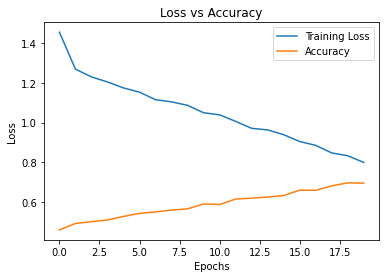

In [ ]:
plt.plot(history_ann.history['loss'])
plt.plot(history_ann.history['accuracy'])
plt.title("Loss vs Accuracy")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Accuracy'], loc='upper right')
plt.show()

> Metrics for our ANN

In [ ]:
y_pred_ann = ann.predict(X_test)
y_classes_ann = [np.argmax(element) for element in y_pred_ann]

print("Classification Report: \n", classification_report(y_test, y_classes_ann))

Classification Report: 
               precision    recall  f1-score   support

           0       0.63      0.79      0.70       129
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        21
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00        29
           5       0.33      0.55      0.41        49

    accuracy                           0.52       250
   macro avg       0.16      0.22      0.19       250
weighted avg       0.39      0.52      0.44       250



## 2. Convolutional Neural Network

* A convolutional neural network is a feed-forward neural network that is generally used to analyze visual images by processing data with grid-like topology
* A convolutional neural network is used to detect and classify objects in an image

* Layers in a Convolutional Neural Network
    A convolution neural network has multiple hidden layers that help in extracting information from an image. The four important layers in CNN are:
    * Convolution layer
    * ReLU layer
    * Pooling layer
    * Fully connected layer
    
 
<center>
<img src="images/cnn.gif" width=1000 />
</center>

> ##  CNN 1 Layer

In [ ]:
cnn = models.Sequential([
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')
])
cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_cnn = cnn.fit(X_train, y_train, epochs=20)

Epoch 1/20
78/78 [==============================] - 11s 133ms/step - loss: 1.6416 - accuracy: 0.4720
Epoch 2/20
78/78 [==============================] - 10s 134ms/step - loss: 1.2128 - accuracy: 0.5167
Epoch 3/20
78/78 [==============================] - 10s 132ms/step - loss: 1.1033 - accuracy: 0.5630
Epoch 4/20
78/78 [==============================] - 11s 135ms/step - loss: 1.0059 - accuracy: 0.6089
Epoch 5/20
78/78 [==============================] - 11s 137ms/step - loss: 0.8799 - accuracy: 0.6672
Epoch 6/20
78/78 [==============================] - 11s 135ms/step - loss: 0.7543 - accuracy: 0.7159
Epoch 7/20
78/78 [==============================] - 10s 134ms/step - loss: 0.6205 - accuracy: 0.7831
Epoch 8/20
78/78 [==============================] - 10s 134ms/step - loss: 0.5130 - accuracy: 0.8294
Epoch 9/20
78/78 [==============================] - 10s 134ms/step - loss: 0.4028 - accuracy: 0.8712
Epoch 10/20
78/78 [==============================] - 13s 162ms/step - loss: 0.3342 - accura

In [ ]:
cnn.evaluate(X_validation,  y_validation)

8/8 [==============================] - 0s 35ms/step - loss: 2.7559 - accuracy: 0.5282


[2.7559361457824707, 0.5282257795333862]

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 61504)             0         
                                                                 
 dense_3 (Dense)             (None, 64)                3936320   
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
Total params: 3,938,502
Trainable params: 3,938,502
Non-trainable params: 0
____________________________________________

### Accuracy for our CNN 1 Layer

> * The Train accuracy is 0.99 
> * The Validation accuracy is 0.52 
> * The Test accuracy is 0.51

> Following is the Graph plotted for Loss vs Accuracy for CNN 1 layer

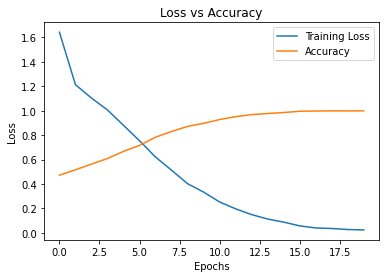

In [ ]:
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['accuracy'])
plt.title("Loss vs Accuracy")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Accuracy'], loc='upper right')
plt.show()

> Metrics for our CNN 1 layer

In [ ]:
y_pred_cnn = cnn.predict(X_test)
y_classes_cnn = [np.argmax(element) for element in y_pred_cnn]

print("Classification Report: \n", classification_report(y_test, y_classes_cnn))

Classification Report: 
               precision    recall  f1-score   support

           0       0.64      0.74      0.68       129
           1       0.00      0.00      0.00         1
           2       0.33      0.19      0.24        21
           3       0.44      0.38      0.41        21
           4       0.17      0.14      0.15        29
           5       0.34      0.33      0.33        49

    accuracy                           0.51       250
   macro avg       0.32      0.30      0.30       250
weighted avg       0.48      0.51      0.49       250



> ## CNN 2 layer

### Data Augmentation

> * To train a good deep learning model we applied some transformations on the data.
> * We did small random transformations (a bit of rotation, zoom, flipping) that doesn’t change what’s inside the image (for the human eye) but changes its pixel values. 
> * Models trained with data augmentation will then generalize better. 
> * Data augmentation is also useful in situations when you have a relatively small number of training samples.

In [ ]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(64, 
                                                              64,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
cnn_2layer = models.Sequential([
    data_augmentation,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(6, activation='softmax')
])
cnn_2layer.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_cnn2layer = cnn_2layer.fit(X_train, y_train, epochs=20)

Epoch 1/20
78/78 [==============================] - 14s 158ms/step - loss: 1.3514 - accuracy: 0.4817
Epoch 2/20
78/78 [==============================] - 11s 147ms/step - loss: 1.2937 - accuracy: 0.4829
Epoch 3/20
78/78 [==============================] - 11s 146ms/step - loss: 1.2792 - accuracy: 0.4994
Epoch 4/20
78/78 [==============================] - 11s 147ms/step - loss: 1.2775 - accuracy: 0.4881
Epoch 5/20
78/78 [==============================] - 11s 145ms/step - loss: 1.2637 - accuracy: 0.4897
Epoch 6/20
78/78 [==============================] - 11s 146ms/step - loss: 1.2680 - accuracy: 0.4833
Epoch 7/20
78/78 [==============================] - 11s 145ms/step - loss: 1.2420 - accuracy: 0.4909
Epoch 8/20
78/78 [==============================] - 11s 145ms/step - loss: 1.2448 - accuracy: 0.4950
Epoch 9/20
78/78 [==============================] - 11s 145ms/step - loss: 1.2344 - accuracy: 0.4998
Epoch 10/20
78/78 [==============================] - 11s 146ms/step - loss: 1.2327 - accura

In [ ]:
cnn_2layer.evaluate(X_validation,  y_validation)

8/8 [==============================] - 0s 37ms/step - loss: 1.0884 - accuracy: 0.5605


[1.0884016752243042, 0.5604838728904724]

In [ ]:
cnn_2layer.evaluate(X_validation,  y_validation)

8/8 [==============================] - 0s 37ms/step - loss: 1.0884 - accuracy: 0.5605


[1.0884016752243042, 0.5604838728904724]

In [ ]:
cnn_2layer.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)       

### Accuracy for our CNN 2 Layer

> * The Train accuracy is 0.55 
> * The Validation accuracy is 0.56 
> * The Test accuracy is 0.59

> Following is the Graph plotted for Loss vs Accuracy for CNN 1 layer

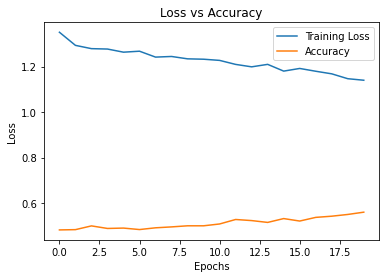

In [ ]:
plt.plot(history_cnn2layer.history['loss'])
plt.plot(history_cnn2layer.history['accuracy'])
plt.title("Loss vs Accuracy")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Accuracy'], loc='upper right')
plt.show()

> Metrics for our CNN 2 layer

In [ ]:
y_pred_cnn2layer = cnn_2layer.predict(X_test)
y_classes_cnn2layer = [np.argmax(element) for element in y_pred_cnn2layer]

print("Classification Report: \n", classification_report(y_test, y_classes_cnn2layer))

Classification Report: 
               precision    recall  f1-score   support

           0       0.60      0.98      0.74       129
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00        21
           3       0.58      0.33      0.42        21
           4       0.00      0.00      0.00        29
           5       0.58      0.29      0.38        49

    accuracy                           0.59       250
   macro avg       0.29      0.27      0.26       250
weighted avg       0.47      0.59      0.49       250



## Conclusion


<center>
<img src="images/brain.gif" height=100 width=1000  />
</center>

* To achieve good classification performance hemorrhages, we provide a number of deep learning models, including artificial neural networks and convolutional neural network models. The CNN 2 layer had the greatest results, with an accuracy of 0.59
* We think this algorithm worked better because we could use transfer learning, and since it had more complexity, it helped to learn our training set
* Lastly, and perhaps most crucially from an objective standpoint, we intend to train the model using the entire dataset rather than just the 2500 images that we were able to use for our training. We anticipate that by doing this, overfitting will be addressed, and we will be able to attain considerably higher precision, recall, and accuracy.
